In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='1'
import torch
import torchvision

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
num_workers = 32
batchsize = 512

transform_train = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
transform_test =torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST(root='data',train=True, 
                                   download=True, transform=transform_train)

test_data = torchvision.datasets.MNIST(root='data',train=False, 
                                   download=True, transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=num_workers)
test_loader =  torch.utils.data.DataLoader(test_data,
                                          batch_size=512,
                                          shuffle=False,
                                          num_workers=num_workers)

In [4]:
# Ultra-simple one layer fully connected network that achieves 92% accuracy on MNIST after trained for 3 epochs
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784,10)

    def forward(self, x):
        bs = x.shape[0]
        x = x.view(bs,-1)
        return self.fc1(x)

model = Net()

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [7]:
md=1000

In [ ]:
for num in range(md):
    model = Net()
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train() 
    model = model.to(device)
    n_epochs = 3
    for epoch in range(n_epochs):
        train_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)
    print(f'Model {num} with loss: {loss}')
    torch.save(model.state_dict(), f'models/{num}')


In [8]:
model = Net()
for num in range(md):
    if num > 5: break
    model.load_state_dict(torch.load(f'models/{num}'))
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() 
    model = model.to(device)
    correct = total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        correct += pred.eq(target.data.view_as(pred)).sum()
        total += target.shape[0]

    print(f'Model {num} with accuracy: {correct*100/total}%')

Model 0 with accuracy: 92.16999816894531%
Model 1 with accuracy: 92.47999572753906%
Model 2 with accuracy: 92.47000122070312%
Model 3 with accuracy: 92.16999816894531%
Model 4 with accuracy: 92.5%
Model 5 with accuracy: 92.38999938964844%


In [9]:
pr =[name for name, param in model.named_parameters() if param.requires_grad]
pr

['fc1.weight', 'fc1.bias']

In [10]:
class stateset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        model = Net()
        self.data=[]
        for a in range(4):
            for x in range(md):
                model.load_state_dict(torch.load(f'models/{x}'))
                self.data.append([param.clone().detach().requires_grad_(False) for name, 
                                  param in model.named_parameters() 
                                  if param.requires_grad ])

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

In [11]:
sset = stateset()
loader = torch.utils.data.DataLoader(
                                   sset,
                                   batch_size=8,
                                   shuffle=True, 
                                   num_workers=32,                         
                                    )


In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1_in = torch.nn.Linear(785*10,128)
        self.clsfr = torch.nn.Linear(128, 1)
    def forward(self, x):
        bs = x[0].shape[0]
        x = torch.concat((x[0], x[1].unsqueeze(-1)), dim=-1).view(bs,-1)
        x =  torch.nn.functional.relu(self.fc1_in(x))
        x = self.clsfr(x)      
        x = torch.sigmoid(x)
        return x


In [19]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()  
        self.generator = torch.nn.Sequential(torch.nn.Linear(1024,1024),
                                             torch.nn.ReLU(),
                                             torch.nn.Linear(1024,7850),
                                             torch.nn.Tanh())
    def forward(self, x):
        
        bs = x.shape[0]
        x = self.generator(x)
        x = x.view(bs,10,785)
        fc1weight = x[:,:,1:]
        fc1bias = x[:,:,:1].squeeze(-1)
        return [fc1weight,fc1bias]


In [20]:
discriminator, generator = Discriminator(), Generator()

In [21]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 1e-4, [0.5, .999])
generator_optimizer = torch.optim.Adam(generator.parameters(), 1e-4, [0.1, .999], weight_decay=2e-5)

In [22]:
def test():
    model = Net()
    weights = generator(torch.rand(1, 1024).cuda())
    model.fc1.weight =torch.nn.Parameter(weights[0].cpu().squeeze())
    model.fc1.bias =torch.nn.Parameter(weights[1].cpu().squeeze())
    model.to(device)
    model.eval() 
    class_correct = class_total =  list(0. for i in range(10))
    correct = total = test_loss = 0.
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        correct += pred.eq(target.data.view_as(pred)).sum()
        total += target.shape[0]
    print(f'Model with accuracy: {correct*100/total}% \n')


In [23]:
def ones(x):
    one = torch.ones(x.size(0)).to(device) 
    return torch.nn.BCELoss()(x.squeeze(), one)

def zeros(x):
    zero = torch.zeros(x.size(0)).to(device) 
    return torch.nn.BCELoss()(x.squeeze(), zero)

In [24]:
discriminator=discriminator.to(device)
generator = generator.to(device)    

for epoch in range(1,10+1):
    for idx, param_l in enumerate(loader):
        param_l = [i.to(device) for i in param_l]
        batch_size = param_l[0].size(0)
        discriminator_optimizer.zero_grad()
        pred1 = discriminator(param_l) 
        loss1 = ones(pred1)
        fake_param = generator(torch.rand(batch_size, 1024).to(device))          
        pred2 = discriminator(fake_param)
        loss2 = zeros(pred2)
        losses = loss1 + loss2
        losses.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        gen = generator(torch.rand(batch_size, 1024).to(device))
        pred3 = discriminator(gen)
        loss3 = ones(pred3)
        loss3.backward()
        generator_optimizer.step()
    print(f'Epoch: {epoch}') 
    test()





Epoch: 1
Model with accuracy: 44.12999725341797% 

Epoch: 2
Model with accuracy: 88.75% 

Epoch: 3
Model with accuracy: 91.19999694824219% 

Epoch: 4
Model with accuracy: 91.93999481201172% 

Epoch: 5
Model with accuracy: 91.83999633789062% 

Epoch: 6
Model with accuracy: 91.58999633789062% 

Epoch: 7
Model with accuracy: 91.86000061035156% 

Epoch: 8
Model with accuracy: 91.65999603271484% 

Epoch: 9
Model with accuracy: 90.80999755859375% 

Epoch: 10
Model with accuracy: 91.83999633789062% 



mean: -0.083660788834095 std: 0.2570497393608093


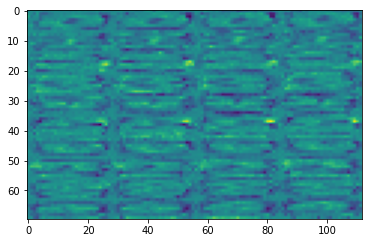

mean: -0.0768371969461441 std: 0.23460958898067474


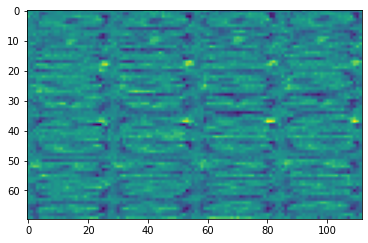

In [68]:
import matplotlib.pyplot as plt
model =Net()
model.load_state_dict(torch.load(f'models/{500}'))
w1_real = model.fc1.weight.detach().view(70,112)
w1_fake = generator(torch.rand(1, 1024).to(device))[0].detach().cpu().view(70,112)
plt.imshow(w1_real)
print(f'mean: {w1_real.mean()} std: {w1_real.std()}')
plt.show()
plt.imshow(w1_fake)
print(f'mean: {w1_fake.mean()} std: {w1_fake.std()}')
plt.show()
